# Random walks $R_t$ factor with constant decay and Gamma-Poisson likelihood

In [ ]:
# NOTE: run this once
# !curl -o all_data.csv https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv

In [1]:
from datetime import date
import pandas as pd
import numpy as np
import pymc3 as pm
from matplotlib import pyplot as plt

import theano.tensor as tt
from theano import scan

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize': [10, 5]})

In [3]:
all_data = pd.read_csv(
    'all_data.csv',
    usecols=['Date', 'Country/Region', 'Confirmed'],
    parse_dates=['Date'],
    infer_datetime_format=True,
)

all_data = all_data.merge(all_data, on='Country/Region', suffixes=['_prev', ''])

all_data = all_data[(all_data.Date - all_data.Date_prev).dt.days == 1]
all_data = all_data.assign(new_cases = (all_data.Confirmed - all_data.Confirmed_prev).fillna(0).astype('int'))
all_data = all_data[['Date', 'Country/Region', 'new_cases']]

In [4]:
# selecting data from France, from the last date without cases
country = 'Germany'
data = all_data[all_data['Country/Region'] == country]
data = data.set_index('Date').sort_index().new_cases.iloc[4:]
data.head()

Date
2020-01-27    1
2020-01-28    3
2020-01-29    0
2020-01-30    0
2020-01-31    1
Name: new_cases, dtype: int64

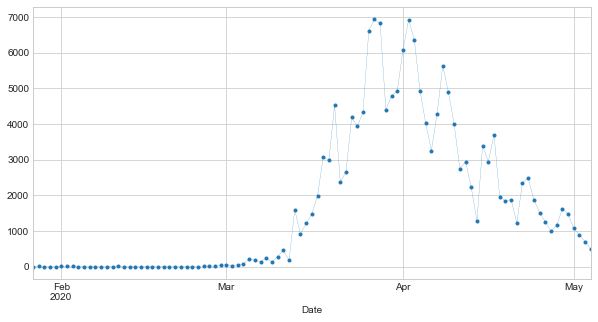

In [5]:
data.plot(linewidth=0.2, marker='.')
None

## Model:

We assume there is an overdispersion in the count, so we use Gamma-Poisson (Negative Binomial):

$$ \text{observed}_t \sim \text{NB}(\lambda_t, \alpha) $$

The poisson parameter satisfies the equation:

$$ \lambda_t = \lambda_{t-1} \exp(R_t - \gamma) $$

where $\gamma$ is a positive decay rate:

$$\gamma \sim \text{HalfNormal}(1^2) $$

The $R$ factor varies daily in the log-scale:

$$ \log(R_t / R_{t-1}) \sim \mathcal{N}(0, \sigma^2) $$

where we put a constraining prior over $\sigma$:

$$\sigma \sim \text{HalfNormal}(0.5^2) $$

Finally, we put a non-informative prior over the dispersion parameter $\alpha$:

$$ \alpha \sim \text{HalfCauchy}(1) $$

In [6]:
N = data.shape[0]

with pm.Model() as model:

    sigma = pm.HalfCauchy('sigma', 0.5)
    logR = pm.GaussianRandomWalk(
        'logR',
        init=pm.Normal.dist(0, 1),
        sigma=sigma,
        shape=N
    )

    # spread
    R = pm.Deterministic('R', pm.math.exp(logR))

    # regular decay
    gamma = pm.Exponential('gamma', 1)

    log_lam = []
    cur_log_lam = np.log(0.1)
    for t in range(0, N):
        cur_log_lam = cur_log_lam + R[t] - gamma
        log_lam.append(cur_log_lam)

    lam = pm.Deterministic('lambda', pm.math.exp(pm.math.stack(log_lam)))

    a0 = pm.HalfCauchy('a0', 1)
    obs = pm.NegativeBinomial('obs', mu=lam, alpha=a0,
                              observed=data.values)

    trace = pm.sample(3000, tune=3000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a0, gamma, logR, sigma]
Sampling 2 chains, 233 divergences: 100%|██████████| 12000/12000 [31:45<00:00,  6.30draws/s]
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [7]:
pm.summary(trace, var_names=['sigma', 'a0', 'gamma'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma,1.026,0.372,0.403,1.708,0.034,0.024,119.0,119.0,115.0,309.0,1.01
a0,9.372,2.092,5.655,13.205,0.054,0.038,1523.0,1523.0,1491.0,3668.0,1.00
gamma,0.071,0.018,0.048,0.109,0.001,0.001,178.0,178.0,197.0,358.0,1.00


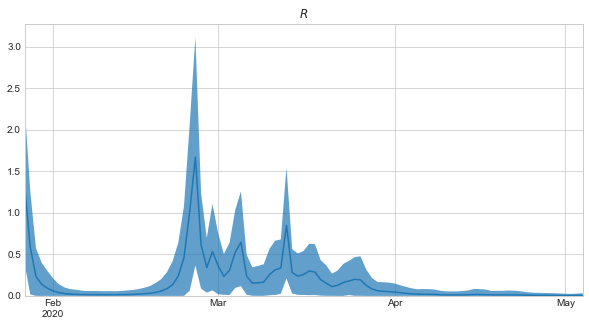

In [9]:
tmp = pm.hpd(trace['R'] , credible_interval=0.95)
tmp = pd.DataFrame(tmp, index=data.reset_index()['Date'])
tmp = tmp.assign(mean_ = trace['R'].mean(axis=0))

plt.figure(figsize=(10, 5))
tmp.mean_.plot()
plt.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.7)
plt.gca().set(title='$R$', xlabel='', ylim=(0, None))
None

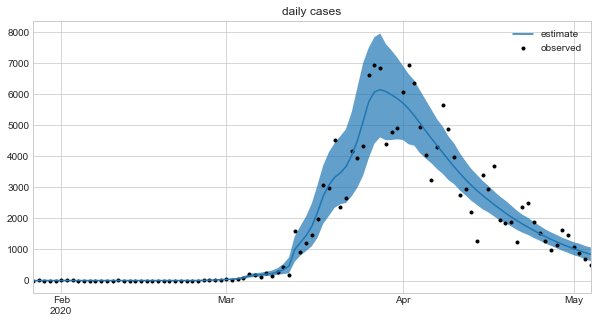

In [11]:
tmp = pm.hpd(trace['lambda'], credible_interval=0.95)
tmp = pd.DataFrame(tmp, index=data.reset_index()['Date'])
tmp = tmp.assign(mean_ = trace['lambda'].mean(axis=0))

plt.figure(figsize=(10, 5))
tmp.mean_.plot(label='estimate')
plt.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.7)
plt.scatter(tmp.index, data, color='k', label='observed', marker='.')
plt.gca().set(title='daily cases', xlabel='')
plt.legend()
None